

# 01 - Исследование и анализ данных проекта
## Детекция факелов и оценка выбросов CO2

**Цель:** Изучить имеющиеся данные, понять их структуру, проверить качество и подготовить план предобработки.


## 1. Импорт библиотек и настройка окружения

In [1]:
import sys
import os
from pathlib import Path
import yaml

In [2]:
# Добавляем src в путь для импорта модулей проекта
project_root = Path.cwd().parent
src_path = project_root / "src"
sys.path.append(str(src_path))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Настройка отображения графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [5]:
# Загрузка конфигурации проекта
with open(project_root / "configs" / "paths.yaml", "r") as f:
    paths_config = yaml.safe_load(f)

## 2. Исследование структуры данных

In [6]:
def explore_data_structure(base_path):
    """Анализирует структуру папок с данными"""
    print("=" * 60)
    print("АНАЛИЗ СТРУКТУРЫ ДАННЫХ")
    print("=" * 60)
    
    data_dirs = {
        "raw": Path(base_path) / "data" / "raw",
        "external": Path(base_path) / "data" / "external",
        "processed": Path(base_path) / "data" / "processed",
        "flaring_gas": Path(base_path) / "flaring-gas"  # старая структура
    }
    
    for name, path in data_dirs.items():
        print(f"\n📁 {name.upper()}: {path}")
        if path.exists():
            # Считаем файлы по типам
            image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
            files = list(path.rglob('*'))
            
            images = [f for f in files if f.suffix.lower() in image_extensions]
            other_files = [f for f in files if f.suffix.lower() not in image_extensions and f.is_file()]
            
            print(f"   📸 Изображений: {len(images)}")
            print(f"   📄 Прочих файлов: {len(other_files)}")
            
            # Показываем структуру каталогов
            if images or other_files:
                print(f"   📂 Подкаталоги:")
                for subdir in sorted(set(f.parent.relative_to(path) for f in files if f.parent != path)):
                    if str(subdir) != '.':
                        print(f"      - {subdir}")
        else:
            print(f"   ❌ Директория не существует")

In [8]:
explore_data_structure(project_root)

АНАЛИЗ СТРУКТУРЫ ДАННЫХ

📁 RAW: e:\Python\MIFI\project-practice\data\raw
   📸 Изображений: 0
   📄 Прочих файлов: 0

📁 EXTERNAL: e:\Python\MIFI\project-practice\data\external
   📸 Изображений: 0
   📄 Прочих файлов: 0

📁 PROCESSED: e:\Python\MIFI\project-practice\data\processed
   📸 Изображений: 0
   📄 Прочих файлов: 0

📁 FLARING_GAS: e:\Python\MIFI\project-practice\flaring-gas
   📸 Изображений: 1052
   📄 Прочих файлов: 0
   📂 Подкаталоги:
      - row
      - train
      - valid


## 3. Анализ изображений в разных источниках

In [9]:
def analyze_images_in_directory(directory_path, max_images=50):
    """Анализирует статистику изображений в указанной директории"""
    if not directory_path.exists():
        print(f"Директория {directory_path} не найдена")
        return None
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    image_files = [f for f in directory_path.rglob('*') 
                  if f.suffix.lower() in image_extensions]
    
    if not image_files:
        print(f"В директории {directory_path} нет изображений")
        return None
    
    print(f"\n📊 АНАЛИЗ ИЗОБРАЖЕНИЙ в {directory_path.name}:")
    print(f"Всего изображений: {len(image_files)}")
    
    # Ограничиваем анализ для скорости
    sample_files = image_files[:min(max_images, len(image_files))]
    
    stats = {
        'paths': [],
        'sizes_mb': [],
        'dimensions': [],
        'formats': [],
        'modes': [],
        'aspect_ratios': []
    }
    
    for img_path in sample_files:
        try:
            with Image.open(img_path) as img:
                stats['paths'].append(img_path)
                stats['sizes_mb'].append(img_path.stat().st_size / (1024 * 1024))
                stats['dimensions'].append(img.size)
                stats['formats'].append(img.format)
                stats['modes'].append(img.mode)
                stats['aspect_ratios'].append(img.width / img.height if img.height > 0 else 0)
        except Exception as e:
            print(f"Ошибка при чтении {img_path}: {e}")
    
    return pd.DataFrame(stats)

In [16]:
# Анализируем разные источники данных
raw_data_path = project_root / "data" / "raw"
external_data_path = project_root / "data" / "external"
flaring_gas_path = project_root / "flaring-gas"
detected_flaring_gas_path = project_root / "flaring-gas"/ "detected"
raw_f_flaring_gas_path = project_root / "flaring-gas"/ "raw-flaring"
train_flaring_gas_path = project_root / "flaring-gas"/ "train"
valid_flaring_gas_path = project_root / "flaring-gas"/ "valid"

In [17]:
df_raw = analyze_images_in_directory(raw_data_path)
df_external = analyze_images_in_directory(external_data_path)
df_flaring = analyze_images_in_directory(flaring_gas_path)
df_detected = analyze_images_in_directory(detected_flaring_gas_path)
df_raw_f = analyze_images_in_directory(raw_f_flaring_gas_path)
df_train = analyze_images_in_directory(train_flaring_gas_path)
df_valid = analyze_images_in_directory(valid_flaring_gas_path)

В директории e:\Python\MIFI\project-practice\data\raw нет изображений
В директории e:\Python\MIFI\project-practice\data\external нет изображений

📊 АНАЛИЗ ИЗОБРАЖЕНИЙ в flaring-gas:
Всего изображений: 1052
В директории e:\Python\MIFI\project-practice\flaring-gas\detected нет изображений

📊 АНАЛИЗ ИЗОБРАЖЕНИЙ в raw-flaring:
Всего изображений: 25

📊 АНАЛИЗ ИЗОБРАЖЕНИЙ в train:
Всего изображений: 987

📊 АНАЛИЗ ИЗОБРАЖЕНИЙ в valid:
Всего изображений: 40


## 4. Визуализация характеристик изображений

In [18]:
def visualize_image_stats(df_dict, title_suffix=""):
    """Визуализирует статистику изображений из разных источников"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Статистика изображений {title_suffix}', fontsize=16, y=1.02)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(df_dict)))
    
    for idx, (source_name, df) in enumerate(df_dict.items()):
        if df is None or df.empty:
            continue
            
        row = idx // 3
        col = idx % 3
        
        # Размеры изображений
        axes[row, col].hist(df['sizes_mb'], bins=20, alpha=0.7, color=colors[idx])
        axes[row, col].set_title(f'{source_name}\n({len(df)} изображений)')
        axes[row, col].set_xlabel('Размер (МБ)')
        axes[row, col].set_ylabel('Количество')
        axes[row, col].grid(True, alpha=0.3)
        
        # Добавляем аннотацию со статистикой
        stats_text = f"Мин: {df['sizes_mb'].min():.2f} МБ\n"
        stats_text += f"Макс: {df['sizes_mb'].max():.2f} МБ\n"
        stats_text += f"Средн: {df['sizes_mb'].mean():.2f} МБ"
        axes[row, col].text(0.95, 0.95, stats_text,
                          transform=axes[row, col].transAxes,
                          fontsize=9, verticalalignment='top',
                          horizontalalignment='right',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Распределение форматов
    if len(df_dict) > 0:
        all_formats = []
        for df in df_dict.values():
            if df is not None:
                all_formats.extend(df['formats'].tolist())
        
        format_counts = pd.Series(all_formats).value_counts()
        axes[1, 2].bar(format_counts.index, format_counts.values, color='skyblue')
        axes[1, 2].set_title('Распределение форматов изображений')
        axes[1, 2].set_xlabel('Формат')
        axes[1, 2].set_ylabel('Количество')
        axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [22]:
# Создаем словарь с данными для визуализации
df_dict = {
    'Raw Data': df_raw,
    'External Data': df_external,
    'Flaring Gas': df_flaring,
    'Flaring Gas Detected': df_detected,
    'Flaring Gas Raw_f': df_raw_f,
    'Flaring Gas Train': df_train,
    'Flaring Gas Valid': df_valid
}

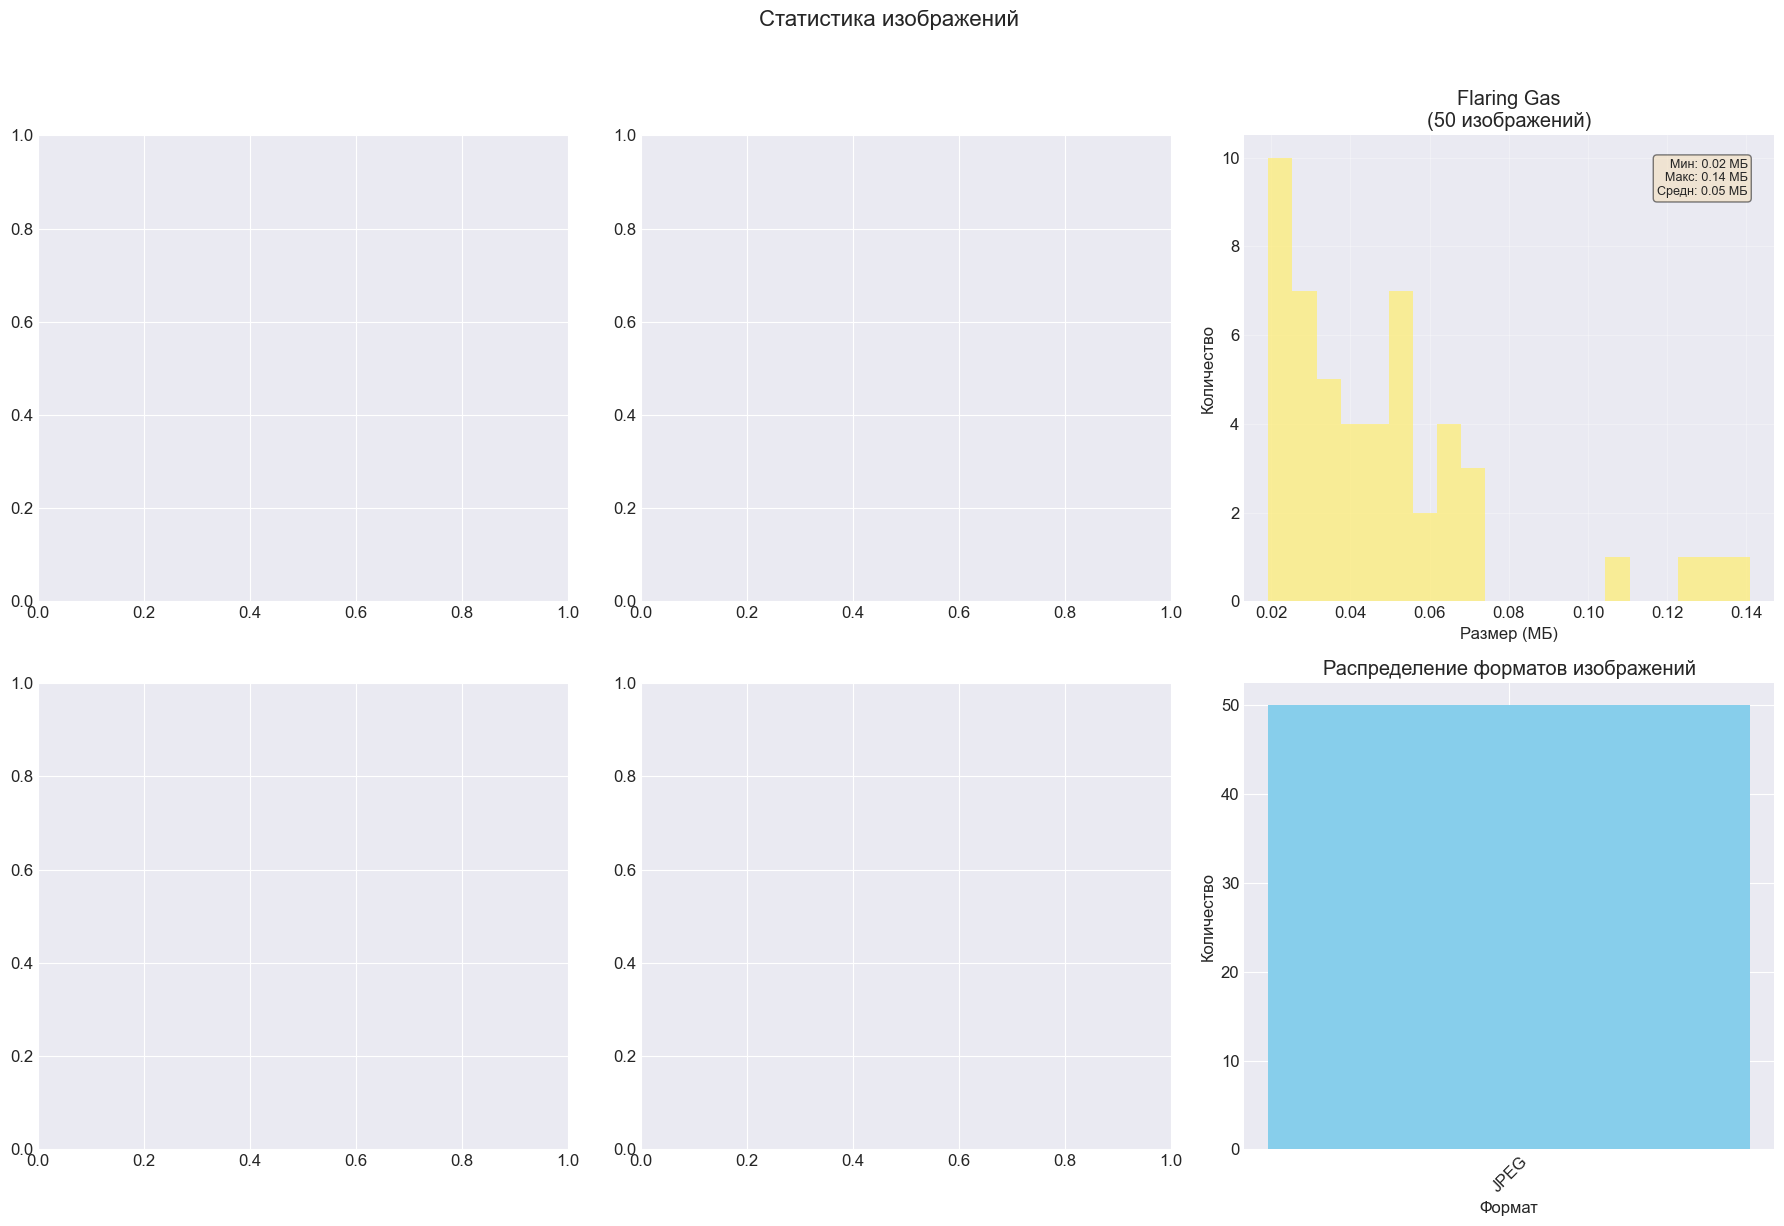

In [20]:
visualize_image_stats(df_dict)

## 5. Анализ размеров и соотношений сторон

In [24]:
def analyze_dimensions(df_dict):
    """Анализ размеров изображений"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    all_widths = []
    all_heights = []
    all_ratios = []
    all_sources = []
    
    for source_name, df in df_dict.items():
        if df is None or df.empty:
            continue
        
        # Извлекаем ширину и высоту
        widths = [dim[0] for dim in df['dimensions']]
        heights = [dim[1] for dim in df['dimensions']]
        ratios = df['aspect_ratios']
        
        all_widths.extend(widths)
        all_heights.extend(heights)
        all_ratios.extend(ratios)
        all_sources.extend([source_name] * len(widths))
    
    if all_widths:
        # Создаем DataFrame для анализа
        dim_df = pd.DataFrame({
            'width': all_widths,
            'height': all_heights,
            'ratio': all_ratios,
            'source': all_sources
        })
        
        # 1. Scatter plot ширины vs высоты
        for source in dim_df['source'].unique():
            source_data = dim_df[dim_df['source'] == source]
            axes[0, 0].scatter(source_data['width'], source_data['height'], 
                             alpha=0.6, label=source, s=50)
        
        axes[0, 0].set_xlabel('Ширина (пиксели)')
        axes[0, 0].set_ylabel('Высота (пиксели)')
        axes[0, 0].set_title('Размеры изображений')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Гистограмма соотношений сторон
        axes[0, 1].hist(dim_df['ratio'], bins=30, alpha=0.7, color='green')
        axes[0, 1].axvline(x=1.0, color='red', linestyle='--', label='Квадрат (1:1)')
        axes[0, 1].axvline(x=4/3, color='orange', linestyle='--', label='4:3')
        axes[0, 1].axvline(x=16/9, color='blue', linestyle='--', label='16:9')
        axes[0, 1].set_xlabel('Соотношение сторон (ширина/высота)')
        axes[0, 1].set_ylabel('Количество')
        axes[0, 1].set_title('Распределение соотношений сторон')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Box plot по источникам
        dim_df['area'] = dim_df['width'] * dim_df['height'] / 1e6  # в мегапикселях
        sns.boxplot(data=dim_df, x='source', y='area', ax=axes[1, 0])
        axes[1, 0].set_xlabel('Источник данных')
        axes[1, 0].set_ylabel('Площадь (мегапиксели)')
        axes[1, 0].set_title('Разброс размеров по источникам')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # 4. Heatmap корреляций
        corr_matrix = dim_df[['width', 'height', 'ratio', 'area']].corr()
        im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', aspect='auto')
        axes[1, 1].set_title('Корреляция параметров изображений')
        
        # Добавляем аннотации
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                axes[1, 1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                              ha='center', va='center', 
                              color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
        
        axes[1, 1].set_xticks(range(len(corr_matrix.columns)))
        axes[1, 1].set_yticks(range(len(corr_matrix.columns)))
        axes[1, 1].set_xticklabels(corr_matrix.columns, rotation=45)
        axes[1, 1].set_yticklabels(corr_matrix.columns)
        plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()

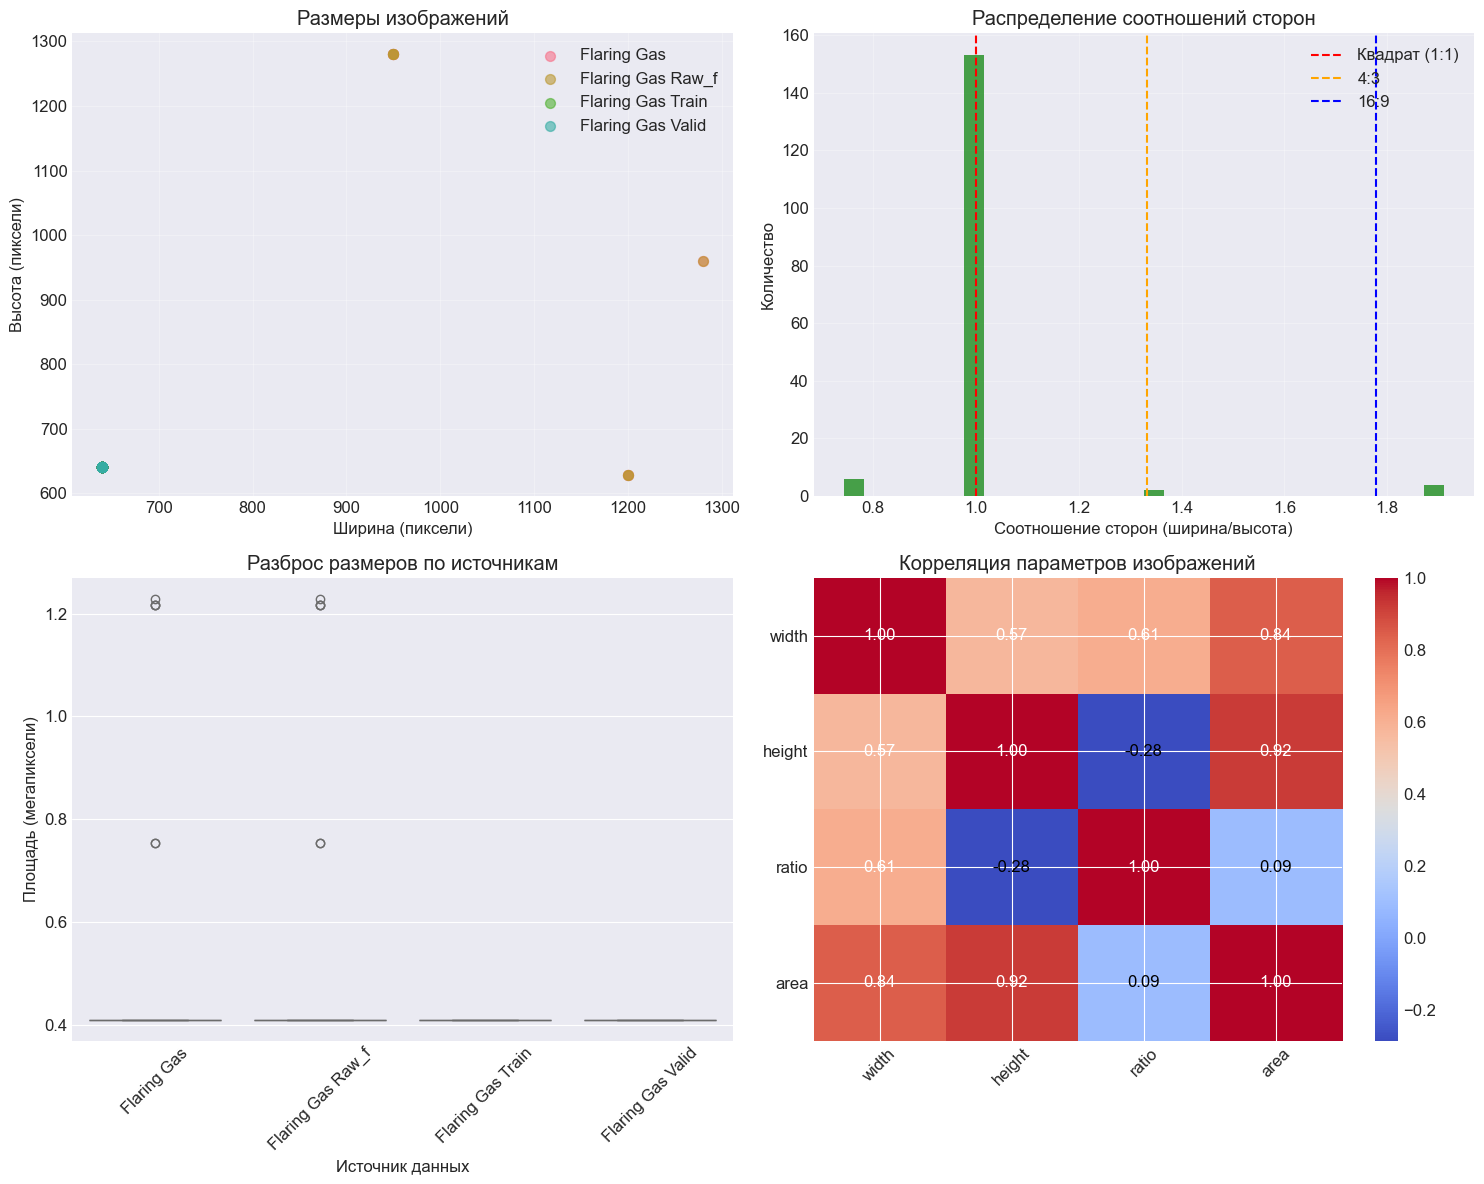

In [25]:
analyze_dimensions(df_dict)

## 6. Просмотр примеров изображений

In [26]:
def display_sample_images(directory_path, n_samples=6):
    """Отображает примеры изображений из директории"""
    if not directory_path.exists():
        print(f"Директория {directory_path} не найдена")
        return
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    image_files = [f for f in directory_path.rglob('*') 
                  if f.suffix.lower() in image_extensions]
    
    if not image_files:
        print(f"В директории нет изображений")
        return
    
    # Выбираем случайные изображения
    np.random.seed(42)
    sample_files = np.random.choice(image_files, 
                                   size=min(n_samples, len(image_files)), 
                                   replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Примеры изображений из {directory_path.name}', fontsize=16, y=1.02)
    
    axes = axes.flatten()
    
    for idx, img_path in enumerate(sample_files):
        if idx >= len(axes):
            break
            
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"{img_path.name}\n{img.size[0]}x{img.size[1]}, {img.format}")
            axes[idx].axis('off')
            
            # Добавляем информацию о файле
            file_size = img_path.stat().st_size / 1024  # в КБ
            info_text = f"{file_size:.1f} KB\n{img.mode}"
            axes[idx].text(0.02, 0.98, info_text,
                          transform=axes[idx].transAxes,
                          fontsize=9, color='white',
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Ошибка:\n{e}",
                          ha='center', va='center',
                          transform=axes[idx].transAxes)
            axes[idx].axis('off')
    
    # Скрываем неиспользуемые subplots
    for idx in range(len(sample_files), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

Примеры из raw данных:
В директории нет изображений

Примеры из external данных:
В директории нет изображений

Примеры из flaring-gas:


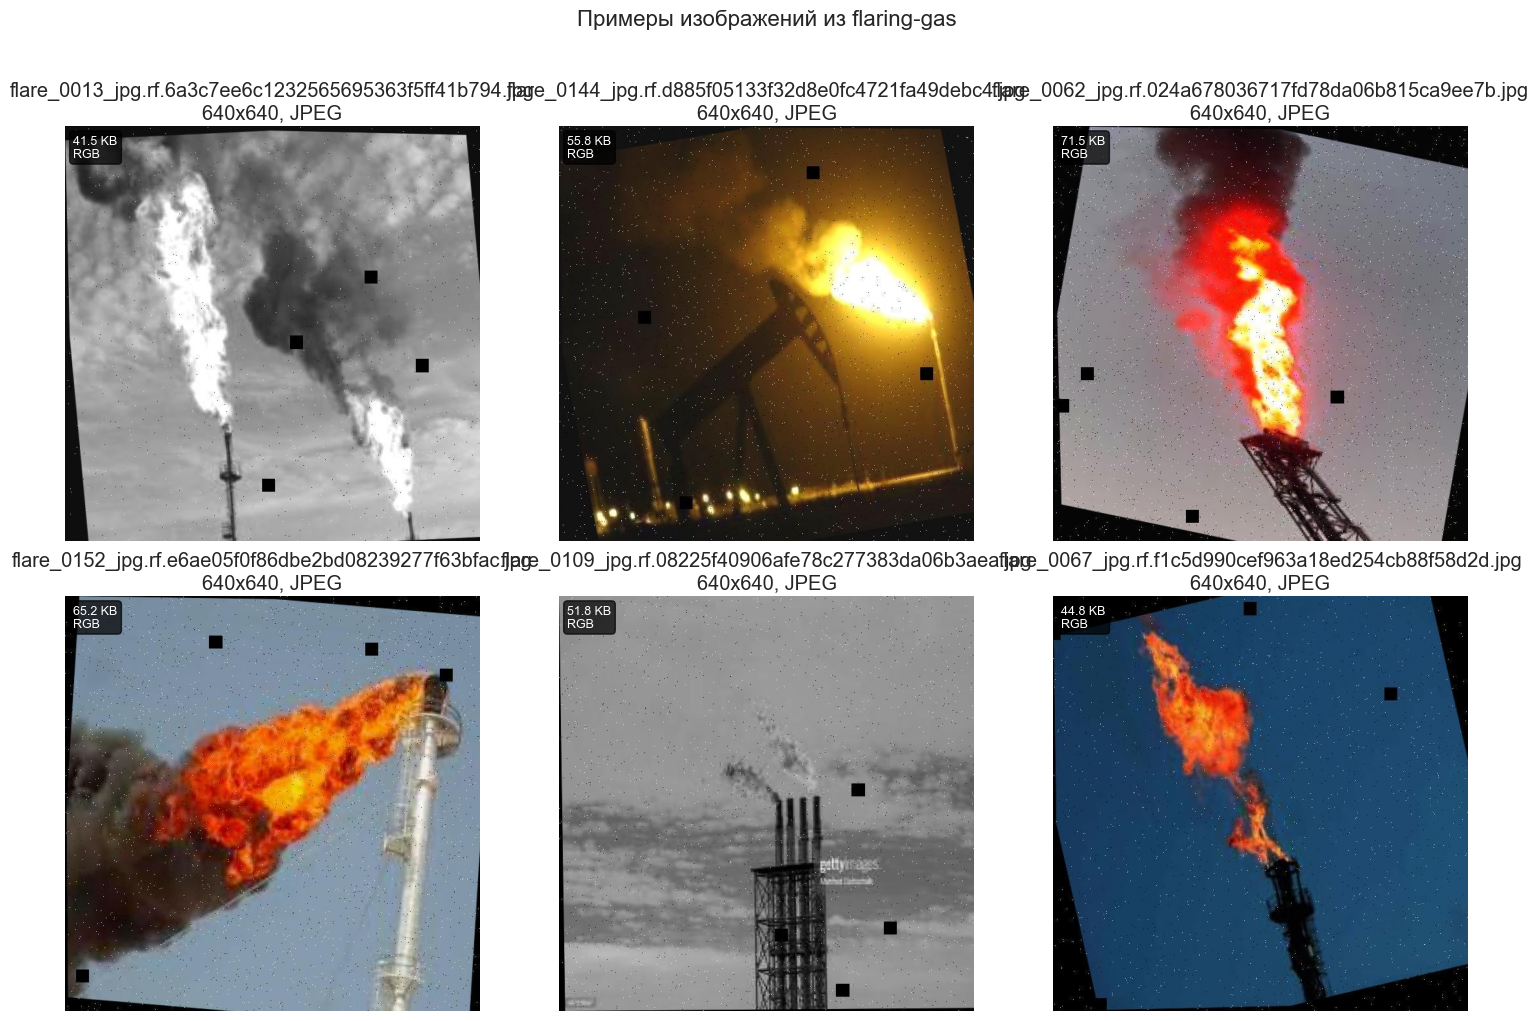

In [27]:
# Показываем примеры из разных источников
print("Примеры из raw данных:")
display_sample_images(raw_data_path)

print("\nПримеры из external данных:")
display_sample_images(external_data_path)

print("\nПримеры из flaring-gas:")
display_sample_images(flaring_gas_path)


## 7. Анализ метаданных и проблем данных

In [28]:
def analyze_data_quality(df_dict):
    """Анализ качества данных"""
    print("=" * 60)
    print("АНАЛИЗ КАЧЕСТВА ДАННЫХ")
    print("=" * 60)
    
    quality_report = {}
    
    for source_name, df in df_dict.items():
        if df is None or df.empty:
            continue
            
        print(f"\n📋 {source_name}:")
        print(f"   Всего изображений: {len(df)}")
        
        # Проверка на пропуски
        missing_values = df.isnull().sum().sum()
        print(f"   Пропущенные значения: {missing_values}")
        
        # Анализ форматов
        formats = df['formats'].value_counts()
        print(f"   Форматы изображений:")
        for fmt, count in formats.items():
            print(f"      - {fmt if fmt else 'Неопределен'}: {count}")
        
        # Анализ цветовых режимов
        modes = df['modes'].value_counts()
        print(f"   Цветовые режимы:")
        for mode, count in modes.items():
            print(f"      - {mode}: {count}")
        
        # Проверка на поврежденные файлы
        corrupted = 0
        for img_path in df['paths']:
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Проверка целостности
            except:
                corrupted += 1
        
        print(f"   Возможно поврежденных: {corrupted}")
        
        # Статистика размеров
        print(f"   Размеры (МБ): мин={df['sizes_mb'].min():.3f}, "
              f"макс={df['sizes_mb'].max():.3f}, "
              f"средн={df['sizes_mb'].mean():.3f}")
        
        quality_report[source_name] = {
            'total_images': len(df),
            'missing_values': missing_values,
            'corrupted': corrupted,
            'avg_size_mb': df['sizes_mb'].mean(),
            'formats': dict(formats),
            'modes': dict(modes)
        }
    
    return quality_report

In [31]:
quality_report = analyze_data_quality(df_dict)

АНАЛИЗ КАЧЕСТВА ДАННЫХ

📋 Flaring Gas:
   Всего изображений: 50
   Пропущенные значения: 0
   Форматы изображений:
      - JPEG: 50
   Цветовые режимы:
      - RGB: 50
   Возможно поврежденных: 0
   Размеры (МБ): мин=0.019, макс=0.141, средн=0.048

📋 Flaring Gas Raw_f:
   Всего изображений: 25
   Пропущенные значения: 0
   Форматы изображений:
      - JPEG: 25
   Цветовые режимы:
      - RGB: 25
   Возможно поврежденных: 0
   Размеры (МБ): мин=0.019, макс=0.141, средн=0.045

📋 Flaring Gas Train:
   Всего изображений: 50
   Пропущенные значения: 0
   Форматы изображений:
      - JPEG: 50
   Цветовые режимы:
      - RGB: 50
   Возможно поврежденных: 0
   Размеры (МБ): мин=0.023, макс=0.070, средн=0.052

📋 Flaring Gas Valid:
   Всего изображений: 40
   Пропущенные значения: 0
   Форматы изображений:
      - JPEG: 40
   Цветовые режимы:
      - RGB: 40
   Возможно поврежденных: 0
   Размеры (МБ): мин=0.016, макс=0.070, средн=0.028


## 8. Рекомендации по предобработке

In [32]:
def generate_preprocessing_recommendations(quality_report, df_dict):
    """Генерация рекомендаций по предобработке"""
    print("\n" + "=" * 60)
    print("РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ")
    print("=" * 60)
    
    recommendations = []
    
    # 1. Рекомендации по размерам
    print("\n1. 📏 РЕКОМЕНДАЦИИ ПО РАЗМЕРАМ ИЗОБРАЖЕНИЙ:")
    
    all_widths = []
    all_heights = []
    for df in df_dict.values():
        if df is not None:
            for dim in df['dimensions']:
                all_widths.append(dim[0])
                all_heights.append(dim[1])
    
    if all_widths:
        avg_width = np.mean(all_widths)
        avg_height = np.mean(all_heights)
        std_width = np.std(all_widths)
        std_height = np.std(all_heights)
        
        print(f"   • Средний размер: {avg_width:.0f}x{avg_height:.0f}")
        print(f"   • Стандартное отклонение: {std_width:.0f}x{std_height:.0f}")
        print(f"   • Рекомендуемый размер для модели: 640x640 или 1024x1024")
        print(f"   • Необходима нормализация размеров перед обучением")
    
    # 2. Рекомендации по форматам
    print("\n2. 🎨 РЕКОМЕНДАЦИИ ПО ФОРМАТАМ И ЦВЕТУ:")
    
    all_modes = []
    for df in df_dict.values():
        if df is not None:
            all_modes.extend(df['modes'].tolist())
    
    mode_counts = pd.Series(all_modes).value_counts()
    print(f"   • Преобладающие цветовые режимы:")
    for mode, count in mode_counts.head(3).items():
        print(f"     - {mode}: {count} изображений")
    
    print(f"   • Рекомендация: конвертировать все в RGB формат")
    print(f"   • Для спутниковых снимков: рассмотреть использование инфракрасных каналов")
    
    # 3. Рекомендации по аугментации
    print("\n3. 🔄 РЕКОМЕНДАЦИИ ПО АУГМЕНТАЦИИ:")
    print("   • Обязательные аугментации:")
    print("     - Random flip (горизонтальный/вертикальный)")
    print("     - Random rotation (±15 градусов)")
    print("     - Brightness/contrast adjustment")
    print("   • Дополнительные для robustness:")
    print("     - Добавление шума (имитация облачности)")
    print("     - Изменение баланса белого")
    print("     - Мозаичная аугментация")
    
    # 4. Рекомендации по разметке
    print("\n4. 🏷️ РЕКОМЕНДАЦИИ ПО РАЗМЕТКЕ:")
    print("   • Формат разметки: YOLO (txt файлы с bounding boxes)")
    print("   • Классы: 'flare' (факел)")
    print("   • Для калибровки: добавить класс 'flare_calibrated' с известными параметрами")
    
    # 5. План действий
    print("\n5. 📋 ПЛАН ДЕЙСТВИЙ:")
    print("   1. Собрать все данные в единую структуру")
    print("   2. Проверить и удалить поврежденные изображения")
    print("   3. Конвертировать все изображения в RGB")
    print("   4. Нормализовать размеры (resize + padding)")
    print("   5. Разметить данные в формате YOLO")
    print("   6. Разделить на train/val/test (70/20/10)")
    print("   7. Применить аугментации для train выборки")
    
    return recommendations

In [40]:
generate_preprocessing_recommendations(quality_report, df_dict)


РЕКОМЕНДАЦИИ ПО ПРЕДОБРАБОТКЕ

1. 📏 РЕКОМЕНДАЦИИ ПО РАЗМЕРАМ ИЗОБРАЖЕНИЙ:
   • Средний размер: 673x667
   • Стандартное отклонение: 122x124
   • Рекомендуемый размер для модели: 640x640 или 1024x1024
   • Необходима нормализация размеров перед обучением

2. 🎨 РЕКОМЕНДАЦИИ ПО ФОРМАТАМ И ЦВЕТУ:
   • Преобладающие цветовые режимы:
     - RGB: 165 изображений
   • Рекомендация: конвертировать все в RGB формат
   • Для спутниковых снимков: рассмотреть использование инфракрасных каналов

3. 🔄 РЕКОМЕНДАЦИИ ПО АУГМЕНТАЦИИ:
   • Обязательные аугментации:
     - Random flip (горизонтальный/вертикальный)
     - Random rotation (±15 градусов)
     - Brightness/contrast adjustment
   • Дополнительные для robustness:
     - Добавление шума (имитация облачности)
     - Изменение баланса белого
     - Мозаичная аугментация

4. 🏷️ РЕКОМЕНДАЦИИ ПО РАЗМЕТКЕ:
   • Формат разметки: YOLO (txt файлы с bounding boxes)
   • Классы: 'flare' (факел)
   • Для калибровки: добавить класс 'flare_calibrated' с извес

[]

## 9. Сохранение отчета

In [45]:
def save_exploration_report(quality_report, df_dict, save_path):
    """Сохраняет отчет об исследовании данных"""
    import json
    import numpy as np
    import pandas as pd
    from pathlib import Path, PurePath, PureWindowsPath, PurePosixPath
    
    # Функция для преобразования pandas/numpy/path объектов
    def convert_for_json(obj):
        # Проверяем на None и NaN сначала
        if obj is None:
            return None
        elif isinstance(obj, float) and np.isnan(obj):
            return None
        
        # Проверяем на Path объекты
        elif isinstance(obj, (Path, PurePath, PureWindowsPath, PurePosixPath)):
            return str(obj)
        
        # Проверяем на pandas/numpy объекты
        elif isinstance(obj, pd.DataFrame):
            return obj.to_dict(orient='records')
        elif isinstance(obj, pd.Series):
            return obj.to_dict()
        elif isinstance(obj, (np.integer, np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32, np.float16)):
            return float(obj)
        elif isinstance(obj, np.bool_):
            return bool(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (pd.Timestamp, pd.DatetimeIndex, pd.DatetimeTZDtype)):
            return str(obj)
        
        # Проверяем на datetime
        elif hasattr(obj, 'isoformat'):
            try:
                return obj.isoformat()
            except:
                return str(obj)
        
        # Рекурсивная обработка словарей и списков
        elif isinstance(obj, dict):
            return {str(k): convert_for_json(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple, set)):
            return [convert_for_json(item) for item in obj]
        
        # Для строк и чисел
        elif isinstance(obj, (str, int, float, bool)):
            return obj
        
        # Для всех остальных типов пытаемся преобразовать в строку
        else:
            try:
                # Сначала пытаемся преобразовать в строку
                str_val = str(obj)
                # Если преобразование успешно и результат не слишком длинный
                if len(str_val) < 1000:
                    return str_val
                else:
                    return f"<{type(obj).__name__} object (truncated)>"
            except:
                return f"<{type(obj).__name__} object (unserializable)>"
    
    # Подробная статистика по файлам из df_dict
    detailed_file_stats = {}
    
    for source_name, df in df_dict.items():
        if df is not None and not df.empty:
            detailed_file_stats[source_name] = {
                'total_files': len(df),
                'file_details': []
            }
            
            # Собираем статистику по каждому файлу
            for idx, row in df.iterrows():
                file_info = {}
                
                # Добавляем все колонки
                for col in df.columns:
                    value = row[col]
                    
                    # Преобразуем значение
                    file_info[col] = convert_for_json(value)
                
                detailed_file_stats[source_name]['file_details'].append(file_info)
            
            # Добавляем сводную статистику по источнику
            if len(df) > 0:
                # Получаем список колонок
                columns_list = []
                for col in df.columns:
                    try:
                        columns_list.append(str(col))
                    except:
                        columns_list.append(f"column_{len(columns_list)}")
                
                detailed_file_stats[source_name].update({
                    'columns': columns_list,
                    'total_columns': len(columns_list)
                })
                
                # Статистика по пропущенным значениям
                missing_dict = {}
                for col in df.columns:
                    try:
                        missing_count = df[col].isnull().sum()
                        missing_dict[str(col)] = int(missing_count)
                    except:
                        missing_dict[str(col)] = 0
                
                detailed_file_stats[source_name]['missing_values'] = missing_dict
                
                # Процент пропущенных значений
                missing_percentage = {}
                for col, count in missing_dict.items():
                    missing_percentage[col] = float(count / len(df) * 100) if len(df) > 0 else 0
                detailed_file_stats[source_name]['missing_percentage'] = missing_percentage
                
                # Типы данных
                dtypes_dict = {}
                for col in df.columns:
                    try:
                        dtype = df[col].dtype
                        dtypes_dict[str(col)] = str(dtype)
                    except:
                        dtypes_dict[str(col)] = 'unknown'
                detailed_file_stats[source_name]['data_types'] = dtypes_dict
                
                # Статистика по числовым колонкам
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                if len(numeric_cols) > 0:
                    numeric_stats = {}
                    for col in numeric_cols:
                        try:
                            col_data = df[col]
                            numeric_stats[str(col)] = {
                                'min': float(col_data.min()) if not col_data.empty and pd.notna(col_data.min()) else None,
                                'max': float(col_data.max()) if not col_data.empty and pd.notna(col_data.max()) else None,
                                'mean': float(col_data.mean()) if not col_data.empty and pd.notna(col_data.mean()) else None,
                                'median': float(col_data.median()) if not col_data.empty and pd.notna(col_data.median()) else None,
                                'std': float(col_data.std()) if not col_data.empty and pd.notna(col_data.std()) else None
                            }
                        except:
                            numeric_stats[str(col)] = {'error': 'Could not compute statistics'}
                    detailed_file_stats[source_name]['numeric_statistics'] = numeric_stats
                
                # Статистика по категориальным колонкам
                categorical_cols = df.select_dtypes(include=['object', 'category']).columns
                if len(categorical_cols) > 0:
                    categorical_stats = {}
                    for col in categorical_cols:
                        try:
                            value_counts = df[col].value_counts().head(10)
                            categorical_stats[str(col)] = {
                                'unique_values': int(df[col].nunique()),
                                'top_values': convert_for_json(value_counts.to_dict()),
                                'most_common': str(value_counts.index[0]) if len(value_counts) > 0 else None
                            }
                        except:
                            categorical_stats[str(col)] = {'error': 'Could not compute statistics'}
                    detailed_file_stats[source_name]['categorical_statistics'] = categorical_stats
    
    # Конвертируем quality_report
    converted_quality_report = {}
    for key, value in quality_report.items():
        converted_quality_report[str(key)] = convert_for_json(value)
    
    # Конвертируем detailed_file_stats
    converted_detailed_stats = convert_for_json(detailed_file_stats)
    
    # Создаем полный отчет
    report = {
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'metadata': {
            'total_data_sources': len(df_dict),
            'data_sources': [str(source) for source in df_dict.keys()],
            'report_version': '1.0'
        },
        'quality_report': converted_quality_report,
        'detailed_file_statistics': converted_detailed_stats,
        'summary': {}
    }
    
    # Сводная статистика
    total_images = 0
    quality_sources = []
    for source, report_data in quality_report.items():
        quality_sources.append(str(source))
        if isinstance(report_data, dict) and 'total_images' in report_data:
            try:
                total_images += int(report_data['total_images'])
            except:
                pass
        elif hasattr(report_data, 'get'):
            try:
                total_images += int(report_data.get('total_images', 0))
            except:
                pass
    
    # Собираем все найденные проблемы
    issues_found = []
    for source, report_data in quality_report.items():
        source_str = str(source)
        if isinstance(report_data, dict):
            # Проверяем различные возможные поля с проблемами
            for issue_field in ['issues', 'problems', 'warnings', 'errors']:
                if issue_field in report_data and report_data[issue_field]:
                    issues = report_data[issue_field]
                    if isinstance(issues, list):
                        for issue in issues:
                            if issue:
                                issues_found.append(f"{source_str}: {convert_for_json(issue)}")
                    elif isinstance(issues, dict):
                        for issue_key, issue_desc in issues.items():
                            issues_found.append(f"{source_str}: {issue_key} - {convert_for_json(issue_desc)}")
    
    # Подсчитываем общее количество файлов
    total_files = 0
    for df in df_dict.values():
        if df is not None and hasattr(df, '__len__'):
            total_files += len(df)
    
    report['summary'] = {
        'total_images_analyzed': int(total_images),
        'total_files_analyzed': total_files,
        'data_sources': quality_sources,
        'recommended_image_size': '640x640',
        'recommended_format': 'RGB',
        'issues_found': issues_found[:50] if issues_found else [],
        'total_issues_found': len(issues_found),
        'analysis_completed': True
    }
    
    # Сохраняем в JSON
    report_path = save_path / "data_exploration_report.json"
    
    # Конвертируем весь отчет
    try:
        final_report = convert_for_json(report)
        with open(report_path, 'w', encoding='utf-8') as f:
            json.dump(final_report, f, ensure_ascii=False, indent=2)
        print(f"✅ Подробный отчет сохранен: {report_path}")
    except Exception as e:
        print(f"⚠️ Ошибка при сохранении полного отчета: {e}")
        print("Попытка сохранить упрощенную версию...")
        
        # Создаем упрощенный отчет
        simplified_report = {
            'timestamp': report['timestamp'],
            'summary': convert_for_json(report['summary']),
            'metadata': convert_for_json(report['metadata']),
            'quality_report_summary': {},
            'file_statistics_summary': {}
        }
        
        # Добавляем краткую информацию из quality_report
        for key, value in quality_report.items():
            if isinstance(value, dict):
                simplified_report['quality_report_summary'][str(key)] = {
                    k: convert_for_json(v) 
                    for k, v in value.items() 
                    if k in ['total_images', 'unique_images', 'missing_annotations', 'class_distribution']
                }
        
        # Добавляем краткую информацию о файлах
        for source_name, df in df_dict.items():
            if df is not None and not df.empty:
                simplified_report['file_statistics_summary'][str(source_name)] = {
                    'total_files': len(df),
                    'total_columns': len(df.columns) if hasattr(df, 'columns') else 0,
                    'columns_sample': [str(col) for col in list(df.columns)[:5]] if hasattr(df, 'columns') else []
                }
        
        try:
            with open(report_path, 'w', encoding='utf-8') as f:
                json.dump(simplified_report, f, ensure_ascii=False, indent=2)
            print(f"✅ Упрощенный отчет сохранен: {report_path}")
        except Exception as e2:
            print(f"❌ Не удалось сохранить даже упрощенный отчет: {e2}")
            # Сохраняем минимальный отчет
            minimal_report = {
                'timestamp': report['timestamp'],
                'total_images_analyzed': total_images,
                'total_files_analyzed': total_files,
                'data_sources': quality_sources,
                'error': f'Failed to save full report: {str(e)}'
            }
            with open(report_path, 'w', encoding='utf-8') as f:
                json.dump(minimal_report, f, ensure_ascii=False, indent=2)
            print(f"✅ Минимальный отчет сохранен: {report_path}")
    
    # Также сохраняем краткий отчет в текстовом формате для быстрого просмотра
    txt_report_path = save_path / "data_exploration_summary.txt"
    try:
        with open(txt_report_path, 'w', encoding='utf-8') as f:
            f.write("=" * 80 + "\n")
            f.write("DATA EXPLORATION REPORT\n")
            f.write("=" * 80 + "\n\n")
            
            f.write(f"Timestamp: {report['timestamp']}\n")
            f.write(f"Total data sources: {len(df_dict)}\n")
            f.write(f"Total images analyzed: {total_images}\n")
            f.write(f"Total files analyzed: {total_files}\n\n")
            
            f.write("Data Sources in df_dict:\n")
            for source in df_dict.keys():
                df = df_dict[source]
                count = len(df) if df is not None else 0
                f.write(f"  - {source}: {count} files\n")
            
            f.write("\nData Sources in quality_report:\n")
            for source in quality_sources:
                f.write(f"  - {source}\n")
            
            f.write("\nFile Statistics by Source:\n")
            for source_name, stats in detailed_file_stats.items():
                if isinstance(stats, dict) and 'total_files' in stats:
                    f.write(f"\n{source_name}:\n")
                    f.write(f"  Files: {stats['total_files']}\n")
                    if 'total_columns' in stats:
                        f.write(f"  Columns: {stats['total_columns']}\n")
                    if 'missing_values' in stats:
                        total_missing = sum(stats['missing_values'].values())
                        f.write(f"  Total missing values: {total_missing}\n")
            
            if issues_found:
                f.write(f"\nIssues Found ({len(issues_found)} total):\n")
                for i, issue in enumerate(issues_found[:20], 1):
                    f.write(f"  {i}. {issue}\n")
                if len(issues_found) > 20:
                    f.write(f"  ... and {len(issues_found) - 20} more issues\n")
            else:
                f.write("\nNo issues found.\n")
    except Exception as e:
        print(f"⚠️ Ошибка при сохранении текстовой сводки: {e}")
    
    if txt_report_path.exists():
        print(f"✅ Краткая сводка сохранена: {txt_report_path}")
    
    # Возвращаем словарь с путями к созданным файлам
    return {
        'json_report': report_path,
        'txt_summary': txt_report_path if txt_report_path.exists() else None,
        'report_data': report,
        'file_statistics': detailed_file_stats
    }


In [46]:
# Сохраняем отчет
results_dir = project_root / "results"
results_dir.mkdir(exist_ok=True)
reports_dir = results_dir / "reports"
reports_dir.mkdir(exist_ok=True)

report = save_exploration_report(quality_report, df_dict, reports_dir)


✅ Подробный отчет сохранен: e:\Python\MIFI\project-practice\results\reports\data_exploration_report.json
✅ Краткая сводка сохранена: e:\Python\MIFI\project-practice\results\reports\data_exploration_summary.txt


## 10. Содержание отчета и вывод датасетов

In [51]:
import json

# Загружаем JSON файл
report_path = reports_dir / "data_exploration_report.json"

with open(report_path, 'r', encoding='utf-8') as f:
    report_data = json.load(f)

In [52]:
# Функция для вывода JSON в виде таблиц
def display_json_as_tables(json_data, max_depth=3, current_depth=0):
    """Рекурсивно отображает JSON данные в виде таблиц"""
    
    if current_depth > max_depth:
        return
    
    if isinstance(json_data, dict):
        # Если это словарь с простыми значениями
        if all(isinstance(v, (str, int, float, bool, type(None))) for v in json_data.values()):
            df = pd.DataFrame([json_data])
            print(f"\n{'='*60}")
            print(f"Таблица: Словарь на глубине {current_depth}")
            print('='*60)
            display(df)
        
        # Если есть вложенные структуры
        else:
            for key, value in json_data.items():
                print(f"\n{'#'*50}")
                print(f"Раздел: {key} (тип: {type(value).__name__})")
                print('#'*50)
                
                if isinstance(value, dict):
                    if len(value) <= 10:  # Небольшие словари показываем как таблицу
                        try:
                            df = pd.DataFrame([value])
                            display(df)
                        except:
                            # Рекурсивно обрабатываем вложенные структуры
                            display_json_as_tables(value, max_depth, current_depth + 1)
                    else:
                        # Для больших словарей показываем первые несколько записей
                        items_list = list(value.items())[:5]
                        df = pd.DataFrame(items_list, columns=['Ключ', 'Значение'])
                        print(f"Показано 5 из {len(value)} записей:")
                        display(df)
                        
                elif isinstance(value, list):
                    if len(value) > 0:
                        if all(isinstance(item, dict) for item in value):
                            # Список словарей - идеально для DataFrame
                            try:
                                df = pd.DataFrame(value)
                                print(f"Таблица со {len(df)} строками и {len(df.columns)} столбцами:")
                                
                                # Ограничиваем вывод для больших таблиц
                                if len(df) > 20:
                                    print(f"Показано первые 20 строк из {len(df)}:")
                                    display(df.head(20))
                                else:
                                    display(df)
                            except:
                                print(f"Список из {len(value)} элементов")
                                for i, item in enumerate(value[:3]):
                                    print(f"  Элемент {i}: {type(item).__name__}")
                        else:
                            print(f"Список из {len(value)} элементов")
                            for i, item in enumerate(value[:5]):
                                print(f"  [{i}]: {item}")
                else:
                    print(f"Значение: {value}")

In [53]:
print("📊 ОТЧЕТ ОБ ИССЛЕДОВАНИИ ДАННЫХ")
print("="*80)

# 1. Основная информация
print("\n1. ОСНОВНАЯ ИНФОРМАЦИЯ")
print("-"*40)
if 'summary' in report_data:
    summary = report_data['summary']
    summary_df = pd.DataFrame([summary])
    display(summary_df)

# 2. Метаданные
print("\n2. МЕТАДАННЫЕ")
print("-"*40)
if 'metadata' in report_data:
    metadata = report_data['metadata']
    metadata_df = pd.DataFrame([metadata])
    display(metadata_df)

# 3. Статистика по источникам данных
print("\n3. СТАТИСТИКА ПО ИСТОЧНИКАМ ДАННЫХ")
print("-"*40)
if 'quality_report' in report_data:
    quality_report = report_data['quality_report']
    
    # Создаем таблицу с ключевыми метриками по источникам
    quality_stats = []
    for source, stats in quality_report.items():
        if isinstance(stats, dict):
            row = {'Источник': source}
            # Добавляем основные метрики
            for key in ['total_images', 'unique_images', 'missing_annotations']:
                if key in stats:
                    row[key] = stats[key]
            quality_stats.append(row)
    
    if quality_stats:
        df = pd.DataFrame(quality_stats)
        display(df)

# 4. Подробная статистика по файлам
print("\n4. ПОДРОБНАЯ СТАТИСТИКА ПО ФАЙЛАМ")
print("-"*40)
if 'detailed_file_statistics' in report_data:
    file_stats = report_data['detailed_file_statistics']
    
    # Сводная таблица по источникам
    summary_data = []
    for source, stats in file_stats.items():
        if isinstance(stats, dict):
            summary_row = {
                'Источник': source,
                'Всего файлов': stats.get('total_files', 0),
                'Всего колонок': stats.get('total_columns', 0)
            }
            
            # Добавляем статистику по пропущенным значениям
            if 'missing_values' in stats:
                missing_vals = stats['missing_values']
                if isinstance(missing_vals, dict):
                    total_missing = sum(v for v in missing_vals.values() if isinstance(v, (int, float)))
                    summary_row['Пропущенные значения'] = total_missing
            
            summary_data.append(summary_row)
    
    if summary_data:
        df = pd.DataFrame(summary_data)
        display(df)
        
        # Показываем детали для каждого источника
        for source, stats in file_stats.items():
            if isinstance(stats, dict) and 'file_details' in stats:
                file_details = stats['file_details']
                if isinstance(file_details, list) and len(file_details) > 0:
                    print(f"\n📁 Детали файлов для источника: {source}")
                    print(f"   Всего файлов: {len(file_details)}")
                    
                    # Создаем DataFrame из первых нескольких файлов
                    try:
                        df_details = pd.DataFrame(file_details[:10])  # Показываем первые 10 файлов
                        display(df_details.head(5))  # Показываем первые 5 строк
                        
                        if len(file_details) > 5:
                            print(f"   ... и еще {len(file_details) - 5} файлов")
                    except:
                        print(f"   Не удалось преобразовать данные в таблицу")

# 5. Распределение классов (если есть)
print("\n5. РАСПРЕДЕЛЕНИЕ КЛАССОВ")
print("-"*40)
if 'quality_report' in report_data:
    class_distributions = []
    
    for source, stats in report_data['quality_report'].items():
        if isinstance(stats, dict) and 'class_distribution' in stats:
            class_dist = stats['class_distribution']
            if isinstance(class_dist, dict):
                for class_name, count in class_dist.items():
                    class_distributions.append({
                        'Источник': source,
                        'Класс': class_name,
                        'Количество': count
                    })
    
    if class_distributions:
        df = pd.DataFrame(class_distributions)
        
        # Группируем по классам для сводной таблицы
        pivot_table = df.pivot_table(
            values='Количество', 
            index='Класс', 
            columns='Источник',
            aggfunc='sum',
            fill_value=0
        )
        
        # Добавляем итоговую колонку
        pivot_table['Всего'] = pivot_table.sum(axis=1)
        
        display(pivot_table)


📊 ОТЧЕТ ОБ ИССЛЕДОВАНИИ ДАННЫХ

1. ОСНОВНАЯ ИНФОРМАЦИЯ
----------------------------------------


,total_images_analyzed,total_files_analyzed,data_sources,recommended_image_size,recommended_format,issues_found,total_issues_found,analysis_completed
0,165,165,"[Flaring Gas, Flaring Gas Raw_f, Flaring Gas T...",640x640,RGB,[],0,True



2. МЕТАДАННЫЕ
----------------------------------------


,total_data_sources,data_sources,report_version
0,7,"[Raw Data, External Data, Flaring Gas, Flaring...",1.0



3. СТАТИСТИКА ПО ИСТОЧНИКАМ ДАННЫХ
----------------------------------------


,Источник,total_images
0,Flaring Gas,50
1,Flaring Gas Raw_f,25
2,Flaring Gas Train,50
3,Flaring Gas Valid,40



4. ПОДРОБНАЯ СТАТИСТИКА ПО ФАЙЛАМ
----------------------------------------


,Источник,Всего файлов,Всего колонок,Пропущенные значения
0,Flaring Gas,50,6,0
1,Flaring Gas Raw_f,25,6,0
2,Flaring Gas Train,50,6,0
3,Flaring Gas Valid,40,6,0



📁 Детали файлов для источника: Flaring Gas
   Всего файлов: 50


,paths,sizes_mb,dimensions,formats,modes,aspect_ratios
0,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.055417,"[1200, 628]",JPEG,RGB,1.910828
1,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.104594,"[1200, 628]",JPEG,RGB,1.910828
2,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.020322,"[640, 640]",JPEG,RGB,1.000000
3,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.019299,"[640, 640]",JPEG,RGB,1.000000
4,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.027690,"[640, 640]",JPEG,RGB,1.000000


   ... и еще 45 файлов

📁 Детали файлов для источника: Flaring Gas Raw_f
   Всего файлов: 25


,paths,sizes_mb,dimensions,formats,modes,aspect_ratios
0,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.055417,"[1200, 628]",JPEG,RGB,1.910828
1,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.104594,"[1200, 628]",JPEG,RGB,1.910828
2,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.020322,"[640, 640]",JPEG,RGB,1.000000
3,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.019299,"[640, 640]",JPEG,RGB,1.000000
4,e:\Python\MIFI\project-practice\flaring-gas\ra...,0.027690,"[640, 640]",JPEG,RGB,1.000000


   ... и еще 20 файлов

📁 Детали файлов для источника: Flaring Gas Train
   Всего файлов: 50


,paths,sizes_mb,dimensions,formats,modes,aspect_ratios
0,e:\Python\MIFI\project-practice\flaring-gas\tr...,0.056496,"[640, 640]",JPEG,RGB,1.0
1,e:\Python\MIFI\project-practice\flaring-gas\tr...,0.046391,"[640, 640]",JPEG,RGB,1.0
2,e:\Python\MIFI\project-practice\flaring-gas\tr...,0.046552,"[640, 640]",JPEG,RGB,1.0
3,e:\Python\MIFI\project-practice\flaring-gas\tr...,0.055472,"[640, 640]",JPEG,RGB,1.0
4,e:\Python\MIFI\project-practice\flaring-gas\tr...,0.034408,"[640, 640]",JPEG,RGB,1.0


   ... и еще 45 файлов

📁 Детали файлов для источника: Flaring Gas Valid
   Всего файлов: 40


,paths,sizes_mb,dimensions,formats,modes,aspect_ratios
0,e:\Python\MIFI\project-practice\flaring-gas\va...,0.021174,"[640, 640]",JPEG,RGB,1.0
1,e:\Python\MIFI\project-practice\flaring-gas\va...,0.028536,"[640, 640]",JPEG,RGB,1.0
2,e:\Python\MIFI\project-practice\flaring-gas\va...,0.021810,"[640, 640]",JPEG,RGB,1.0
3,e:\Python\MIFI\project-practice\flaring-gas\va...,0.028365,"[640, 640]",JPEG,RGB,1.0
4,e:\Python\MIFI\project-practice\flaring-gas\va...,0.018879,"[640, 640]",JPEG,RGB,1.0


   ... и еще 35 файлов

5. РАСПРЕДЕЛЕНИЕ КЛАССОВ
----------------------------------------
